In [1]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Read CSV file to get Spotify IDs and song names
csv_file_path = 'Dataset/spotify_preview_target_non.csv'
df_csv = pd.read_csv(csv_file_path)

# Step 2: Match with MP3 files in Genre_Check folder
genre_folder = 'Dataset/Genre_Check'
output_folder = 'Output'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize lists to store extracted features
spotify_ids = []
genres = []
waveforms = []

# Iterate through each genre folder
for genre in os.listdir(genre_folder):
    genre_path = os.path.join(genre_folder, genre)
    
    # Iterate through each MP3 file in the genre folder
    for filename in tqdm(os.listdir(genre_path), desc=f'Processing Genre: {genre}'):
        file_path = os.path.join(genre_path, filename)
        
        # Extract Spotify ID and genre from the file name
        filename_parts = filename.replace('.mp3', '').split('-')
        
        if len(filename_parts) == 2:
            song_name, spotify_id = filename_parts
            genre_name = genre.lower()
            
            # Check if the Spotify ID is present in the CSV file
            matching_row = df_csv[df_csv['spotify_id'] == spotify_id]
            if not matching_row.empty:
                # Extract features from the MP3 file
                y, sr = librosa.load(file_path, duration=30)
                waveform_features = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
                
                # Store the extracted features
                spotify_ids.append(spotify_id)
                genres.append(genre_name)
                waveforms.append(waveform_features)

# Save extracted features to CSV file
output_csv_path = os.path.join(output_folder, 'spotify_genre_waveform.csv')
df_output = pd.DataFrame({'spotify_id': spotify_ids, 'genre': genres, 'waveform': waveforms})
df_output.to_csv(output_csv_path, index=False)

print(f"Extracted features saved to {output_csv_path}")


Processing Genre: west coast rap: 100%|██████████| 167/167 [00:34<00:00,  4.89it/s]


Extracted features saved to Output\spotify_genre_waveform.csv


In [2]:
# Step 4: Calculate similarity matrix
# Extracted features from the CSV file
features_matrix = np.array(df_output['waveform'].to_list())

# Compute pairwise cosine similarity matrix (1 for similar, 0 for dissimilar)
threshold = 0.9  # Set desired threshold value
similarity_matrix = cosine_similarity(features_matrix, features_matrix) >= threshold

# Save similarity matrix to CSV file
output_similarity_matrix_path = os.path.join(output_folder, 'spotify_genre_similarity_matrix.csv')
df_similarity_matrix = pd.DataFrame(similarity_matrix.astype(int), index=spotify_ids, columns=spotify_ids)
df_similarity_matrix.to_csv(output_similarity_matrix_path)

print(f"Similarity matrix saved to {output_similarity_matrix_path}")

Similarity matrix saved to Output\spotify_genre_similarity_matrix.csv


In [88]:
# Verify Similarity Matrix
print("\nVerifying Similarity Matrix:")

# Check if the matrix is square
if df_similarity_matrix.shape[0] == df_similarity_matrix.shape[1]:
    print("Similarity matrix is square.")
else:
    print("Error: Similarity matrix is not square.")

# Check if the matrix indices match Spotify IDs
if df_similarity_matrix.index.equals(df_similarity_matrix.columns):
    print("Row and column indices match Spotify IDs.")
else:
    print("Error: Row and column indices do not match.")

# Check if values are either 0 or 1
if set(df_similarity_matrix.values.flatten()) == {0, 1}:
    print("Values in the similarity matrix are either 0 or 1.")
else:
    print("Error: Values in the similarity matrix are not correct.")

# Print a sample of the similarity matrix
print("\nSample of the Similarity Matrix:")
print(df_similarity_matrix.head())


Verifying Similarity Matrix:
Similarity matrix is square.
Row and column indices match Spotify IDs.
Values in the similarity matrix are either 0 or 1.

Sample of the Similarity Matrix:
spotify_id              66v57SIfLYJYGYu2WkWiSJ  4ghvDvK0tWXLfvG4znwpAe  \
spotify_id                                                               
66v57SIfLYJYGYu2WkWiSJ                       1                       0   
4ghvDvK0tWXLfvG4znwpAe                       0                       1   
04O45djDgdvw08HOkouSKW                       0                       1   
73GEVn1tqk9bn0KbtWsiqj                       0                       1   
3ohWkpSBpimp9jXbvDETR1                       0                       1   

spotify_id              04O45djDgdvw08HOkouSKW  73GEVn1tqk9bn0KbtWsiqj  \
spotify_id                                                               
66v57SIfLYJYGYu2WkWiSJ                       0                       0   
4ghvDvK0tWXLfvG4znwpAe                       1                       1   

In [31]:
import pandas as pd

# Load the waveform data
waveform_data = pd.read_csv("Output/spotify_genre_waveform.csv")

# Manually create ground truth labels for a subset of the data
# For simplicity, let's assume you have a column called 'genre' in your dataframe
# where you've manually labeled a portion of your data
ground_truth = waveform_data[['spotify_id', 'genre']]

# Save ground truth to CSV
ground_truth.to_csv("Output/spotify_ground_truth.csv", index=False)

Accuracy on the test set: 4.25%
Unique labels in ground truth: ['acoustic blues' 'blues' 'blues-rock' 'british blues' 'chicago blues'
 'country blues' 'deep delta blues' 'delta blues' 'dirty south rap'
 'electric blues' 'gangster rap' 'garage punk blues' 'gospel blues'
 'harmonica blues' 'j-rap' 'jazz blues' 'jump blues' 'louisiana blues'
 'memphis blues' 'modern blues' 'new orleans blues' 'piano blues'
 'piedmont blues' 'pop rap' 'power blues-rock' 'rap' 'soul blues'
 'southern soul blues' 'swamp blues' 'texas blues' 'traditional blues'
 'underground pop rap' 'west coast rap']
Classifier classes: ['acoustic blues' 'blues' 'blues-rock' 'british blues' 'chicago blues'
 'country blues' 'deep delta blues' 'delta blues' 'dirty south rap'
 'electric blues' 'gangster rap' 'garage punk blues' 'gospel blues'
 'harmonica blues' 'j-rap' 'jazz blues' 'jump blues' 'louisiana blues'
 'memphis blues' 'modern blues' 'new orleans blues' 'piano blues'
 'piedmont blues' 'pop rap' 'rap' 'soul blues' 'swa

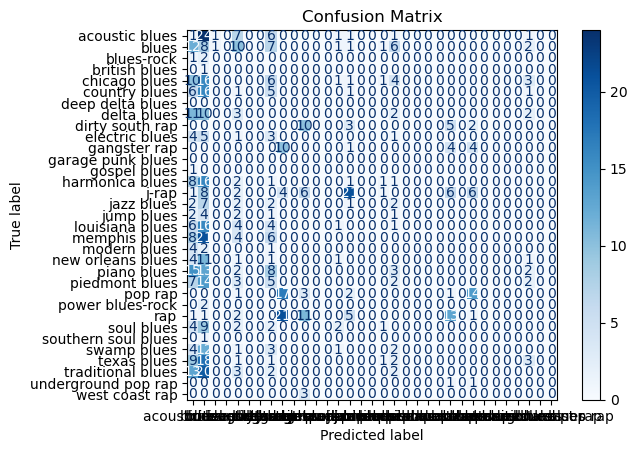

In [95]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

# Load the similarity matrix
similarity_matrix = pd.read_csv("Output/spotify_genre_similarity_matrix.csv", index_col=0)

# Load the ground truth
ground_truth = pd.read_csv("Output/spotify_ground_truth.csv")

# Merge similarity matrix with ground truth using 'spotify_id'
data = pd.merge(similarity_matrix, ground_truth, how='inner', left_index=True, right_on='spotify_id')

# Separate features (X) and labels (y)
X = data.drop(['spotify_id', 'genre'], axis=1)
y = data['genre']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple decision tree classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predict genres for the test set
predicted_labels_test = classifier.predict(X_test)

# Evaluate the accuracy
accuracy_test = accuracy_score(y_test, predicted_labels_test)
print(f"Accuracy on the test set: {accuracy_test:.2%}")

# Verify unique labels
unique_labels_y = unique_labels(y)
print(f"Unique labels in ground truth: {unique_labels_y}")

# Verify classifier classes
print(f"Classifier classes: {classifier.classes_}")

# Use unique labels for display_labels in ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_test, predicted_labels_test, labels=unique_labels_y)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=unique_labels_y)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
disp.ax_.set_title('Confusion Matrix')
plt.savefig('Output/confusion_matrix.png')
plt.show()

In [42]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Step 1: Read CSV file to get Spotify IDs and song names
csv_file_path = 'Dataset/spotify_preview_target_non.csv'
df_csv = pd.read_csv(csv_file_path)

# Step 2: Match with MP3 files in Genre_Check folder
genre_folder = 'Dataset/Genre_Check'
output_folder = 'Output'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize lists to store extracted features
spotify_ids = []
genres = []
mfccs_list = []
spectral_centroids_list = []
zcr_list = []
chroma_list = []
spectral_rolloff_list = []

# Iterate through each genre folder
for genre in os.listdir(genre_folder):
    genre_path = os.path.join(genre_folder, genre)
    
    # Iterate through each MP3 file in the genre folder
    for filename in tqdm(os.listdir(genre_path), desc=f'Processing Genre: {genre}'):
        file_path = os.path.join(genre_path, filename)
        
        # Extract Spotify ID and genre from the file name
        filename_parts = filename.replace('.mp3', '').split('-')
        
        if len(filename_parts) == 2:
            song_name, spotify_id = filename_parts
            genre_name = genre.lower()
            
            # Check if the Spotify ID is present in the CSV file
            matching_row = df_csv[df_csv['spotify_id'] == spotify_id]
            if not matching_row.empty:
                # Extract features from the MP3 file
                y, sr = librosa.load(file_path, duration=30)
                
                # Extract MFCCs
                mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
                
                # Extract Spectral Centroid
                spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
                
                # Extract Zero Crossing Rate (ZCR)
                zcr = np.mean(librosa.feature.zero_crossing_rate(y))
                
                # Extract Chroma Frequencies
                chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
                
                # Extract Spectral Roll-off
                spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
                
                # Store the extracted features
                spotify_ids.append(spotify_id)
                genres.append(genre_name)
                mfccs_list.append(mfccs)
                spectral_centroids_list.append(spectral_centroid)
                zcr_list.append(zcr)
                chroma_list.append(chroma)
                spectral_rolloff_list.append(spectral_rolloff)

# Save extracted features to CSV file
output_csv_path = os.path.join(output_folder, 'spotify_genre_waveform.csv')
df_output = pd.DataFrame({
    'spotify_id': spotify_ids,
    'genre': genres,
    'mfccs': mfccs_list,
    'spectral_centroid': spectral_centroids_list,
    'zcr': zcr_list,
    'chroma': chroma_list,
    'spectral_rolloff': spectral_rolloff_list
})
df_output.to_csv(output_csv_path, index=False)

print(f"Extracted features saved to {output_csv_path}")

Processing Genre: rap: 100%|██████████| 198/198 [02:01<00:00,  1.64it/s]


Extracted features saved to Output\spotify_genre_waveform.csv


In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity

# Custom function to convert string representation of lists to actual lists
def convert_to_list(x):
    try:
        return eval(x) if pd.notnull(x) else np.nan
    except:
        return np.nan

# Load your data
df_output = pd.read_csv("Output/spotify_genre_waveform.csv")

# Extracted features from the CSV file
feature_columns = ['mfccs', 'spectral_centroid', 'zcr', 'chroma', 'spectral_rolloff']

# Apply the custom function to the 'mfccs' and 'chroma' columns
features_matrix = df_output[feature_columns].copy()
for column in ['mfccs', 'chroma']:
    features_matrix[column] = features_matrix[column].apply(convert_to_list)

# Convert the data type to float to enable NaN and Inf checks
features_matrix = features_matrix.astype(float)

# Handle missing values for 'mfccs' column
mfccs_col = 'mfccs'
if features_matrix[mfccs_col].notnull().any():
    imputer_mfccs = SimpleImputer(strategy='mean')
    mfccs_imputed = pd.DataFrame(imputer_mfccs.fit_transform(features_matrix[mfccs_col].to_numpy().reshape(-1, 1)), columns=[mfccs_col])
else:
    mfccs_imputed = features_matrix[[mfccs_col]]

# Handle missing values for 'chroma' column
chroma_col = 'chroma'
if features_matrix[chroma_col].notnull().any():
    imputer_chroma = SimpleImputer(strategy='mean')
    chroma_imputed = pd.DataFrame(imputer_chroma.fit_transform(features_matrix[chroma_col].to_numpy().reshape(-1, 1)), columns=[chroma_col])
else:
    chroma_imputed = features_matrix[[chroma_col]]

# Concatenate imputed columns with the rest of the features
features_matrix_imputed = pd.concat([mfccs_imputed, features_matrix.drop(columns=[mfccs_col, chroma_col]), chroma_imputed], axis=1)

# Use SimpleImputer to replace NaN values with the mean for other columns
missing_cols = features_matrix_imputed.columns[features_matrix_imputed.isnull().any()].tolist()
for col in missing_cols:
    if features_matrix_imputed[col].notnull().any():
        imputer = SimpleImputer(strategy='mean')
        features_matrix_imputed[col] = imputer.fit_transform(features_matrix_imputed[col].to_numpy().reshape(-1, 1))
    else:
        features_matrix_imputed[col] = 0  # Fallback to a default value when all values are missing

# Normalize features
scaler = StandardScaler()

# Check if the data is 1D (e.g., a single sequence)
if len(features_matrix_imputed.shape) == 1:
    features_matrix_imputed = features_matrix_imputed.reshape(-1, 1)

features_matrix_normalized = scaler.fit_transform(features_matrix_imputed)

# Reshape features_matrix_normalized back to 2D
features_matrix_normalized = pd.DataFrame(features_matrix_normalized, columns=feature_columns)

# Apply weights to features if needed
# You can experiment with different weights based on the importance of each feature
weights = np.array([1.0] * features_matrix_normalized.shape[1])  # Example: equal weights

# Multiply features by weights
features_matrix_weighted = features_matrix_normalized * weights

# Compute pairwise cosine similarity matrix (1 for similar, 0 for dissimilar)
threshold = 0.7  # Set the desired threshold value
similarity_matrix = cosine_similarity(features_matrix_weighted, features_matrix_weighted) >= threshold

# Save similarity matrix to CSV file
output_similarity_matrix_path = "Output/spotify_genre_similarity_matrix.csv"  # Specify your desired output path
df_similarity_matrix = pd.DataFrame(similarity_matrix.astype(int), index=df_output['spotify_id'], columns=df_output['spotify_id'])
df_similarity_matrix.to_csv(output_similarity_matrix_path)

print(f"Similarity matrix saved to {output_similarity_matrix_path}")

# Print a sample of the similarity matrix
print("\nSample of the Similarity Matrix (Top 5 rows and columns):")
print(df_similarity_matrix.head())


Similarity matrix saved to Output/spotify_genre_similarity_matrix.csv

Sample of the Similarity Matrix (Top 5 rows and columns):
spotify_id              66v57SIfLYJYGYu2WkWiSJ  4ghvDvK0tWXLfvG4znwpAe  \
spotify_id                                                               
66v57SIfLYJYGYu2WkWiSJ                       1                       0   
4ghvDvK0tWXLfvG4znwpAe                       0                       1   
04O45djDgdvw08HOkouSKW                       0                       1   
73GEVn1tqk9bn0KbtWsiqj                       0                       1   
3ohWkpSBpimp9jXbvDETR1                       0                       1   

spotify_id              04O45djDgdvw08HOkouSKW  73GEVn1tqk9bn0KbtWsiqj  \
spotify_id                                                               
66v57SIfLYJYGYu2WkWiSJ                       0                       0   
4ghvDvK0tWXLfvG4znwpAe                       1                       1   
04O45djDgdvw08HOkouSKW                       1          